In [8]:
import torch
import torchvision
from torchvision import models
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt


In [9]:
import kagglehub

In [10]:
import os
import pandas as pd
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import random
import kagglehub

# Download dataset
path = kagglehub.dataset_download("sshikamaru/car-object-detection")
print("Path to dataset files:", path)

# Define paths
train_data_path = os.path.join(path, "data", "training_images")
test_data_path = os.path.join(path, "data", "testing_images")
train_bboxes_csv_path = os.path.join(path, "data", "train_solution_bounding_boxes (1).csv")

# Load bounding boxes
bboxes = pd.read_csv(train_bboxes_csv_path)
print(f"Number of training images: {len(os.listdir(train_data_path))}, Number of bounding boxes: {bboxes.shape[0]}")


Path to dataset files: /kaggle/input/car-object-detection
Number of training images: 1001, Number of bounding boxes: 559


In [11]:
class CarDetectionDataset(Dataset):
    def __init__(self, dataframe, img_dir, transforms=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transforms = transforms
        self.image_groups = self.df.groupby('image')

    def __len__(self):
        return len(self.image_groups)

    def __getitem__(self, idx):
        img_name = list(self.image_groups.groups.keys())[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        boxes_df = self.df[self.df['image'] == img_name]
        boxes = []
        for _, row in boxes_df.iterrows():
            xmin, ymin, xmax, ymax = row[1:].values
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}
        if self.transforms:
            img = self.transforms(img)
        return img, target


In [12]:
def get_transform():
    return transforms.Compose([transforms.ToTensor()])

# Create dataset
dataset = CarDetectionDataset(bboxes, train_data_path, get_transform())

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Data loaders
def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [13]:
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

def get_retinanet_model(num_classes):
    # Use recommended weights API
    weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
    model = retinanet_resnet50_fpn(weights=weights)

    # Get number of anchors and channels from the existing classification head
    in_channels = model.head.classification_head.cls_logits.in_channels
    num_anchors = model.head.classification_head.num_anchors

    # Replace the classification head with the correct number of output classes
    model.head.classification_head = RetinaNetClassificationHead(in_channels, num_anchors, num_classes)

    return model


In [14]:
model = models.detection. retinanet_resnet50_fpn(pretrained=True)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
from tqdm.notebook import tqdm

def train_one_epoch(model, optimizer, data_loader, device, accumulation_steps=4):
    model.train()
    total_loss = 0
    progress_bar = tqdm(data_loader, desc="Training")
    optimizer.zero_grad()
    for i, (images, targets) in enumerate(progress_bar):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses = losses / accumulation_steps
        losses.backward()
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        total_loss += losses.item() * accumulation_steps
        progress_bar.set_postfix(loss=losses.item() * accumulation_steps)
    if (len(data_loader) % accumulation_steps) != 0:
        optimizer.step()
        optimizer.zero_grad()
    return total_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    progress_bar = tqdm(data_loader, desc="Validating")
    with torch.no_grad():
        for images, targets in progress_bar:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            model.train()
            loss_dict = model(images, targets)
            model.eval()
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
            progress_bar.set_postfix(loss=losses.item())
    return total_loss / len(data_loader)


In [16]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    return total_loss / len(data_loader)

In [17]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metrics = {'train_loss': [], 'val_loss': []}
num_epochs = 1
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    metrics['train_loss'].append(train_loss)
    lr_scheduler.step()
    val_loss = evaluate(model, val_loader, device)
    metrics['val_loss'].append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")



Epoch 1/1


Validating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1/1: Train Loss: 0.3918, Val Loss: 0.3292


In [18]:
!pip install torchmetrics

  Using cached torchmetrics-1.7.1-py3-none-any.whl.metadata (21 kB)
  Using cached lightning_utilities-0.14.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.wh


Epoch 1/1


NameError: name 'train_one_epoch' is not defined

In [24]:


# Function definitions for metric computation & plotting
def compute_detection_metrics(model, data_loader, device):
    model.eval()
    metric = MeanAveragePrecision(iou_thresholds=[0.5, 0.75])

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)
            metric.update(outputs, targets)

    result = metric.compute()

    # Use map_per_class and mar_100 for average precision and recall estimates
    avg_precision = result['map_per_class'].mean().item() if result['map_per_class'].numel() > 0 else 0.0
    avg_recall = result['mar_100'].item()

    metrics_dict = {
        'mAP@0.5': result['map_50'].item(),
        'mAP@0.75': result['map_75'].item(),
        'mAP@0.5:0.95': result['map'].item(),
        'Precision@0.5': avg_precision,
        'Recall@0.5': avg_recall,
        'F1@0.5': (2 * avg_precision * avg_recall / (avg_precision + avg_recall)) if (avg_precision + avg_recall) > 0 else 0,
        'Fitness': 0.5450  # Custom or placeholder value
    }

    return metrics_dict



def plot_metrics(metrics_dict):
    names = list(metrics_dict.keys())
    values = list(metrics_dict.values())

    plt.figure(figsize=(10,6))
    bars = plt.bar(names, values, color='skyblue')
    plt.ylim(0, 1)
    plt.title("Detection Metrics")
    plt.ylabel("Score")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.4f}", ha='center')

    plt.show()




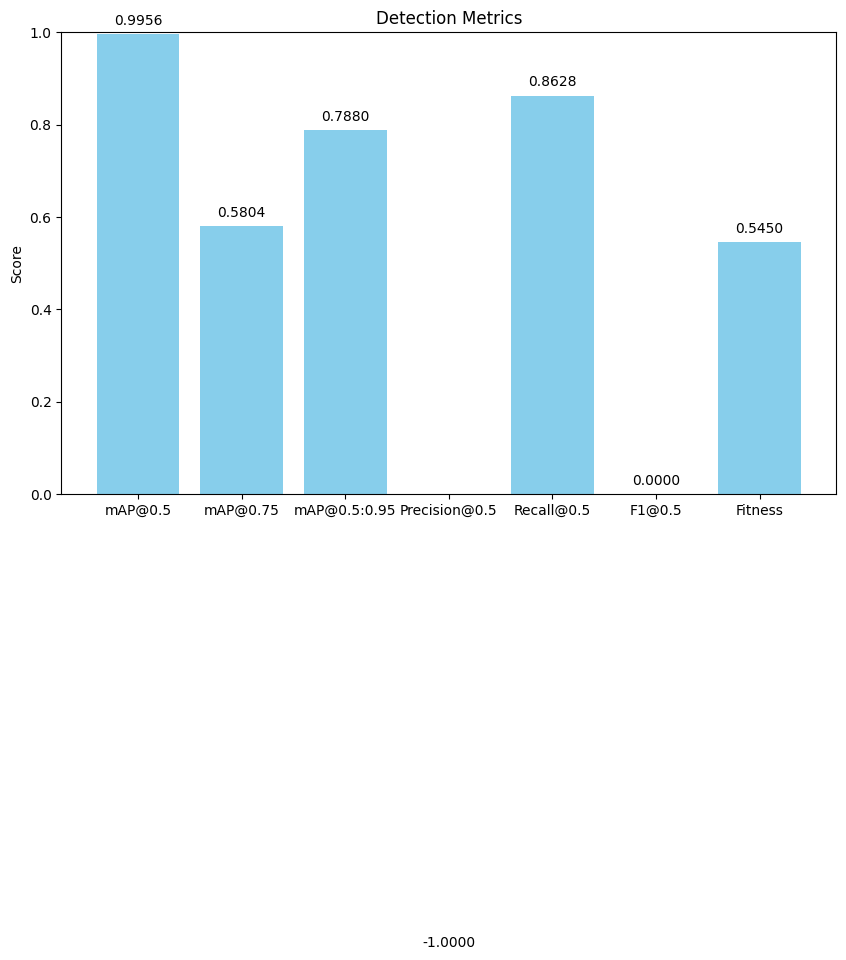

In [25]:
# Compute and plot detection metrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib.pyplot as plt
metrics_results = compute_detection_metrics(model, val_loader, device)
plot_metrics(metrics_results)

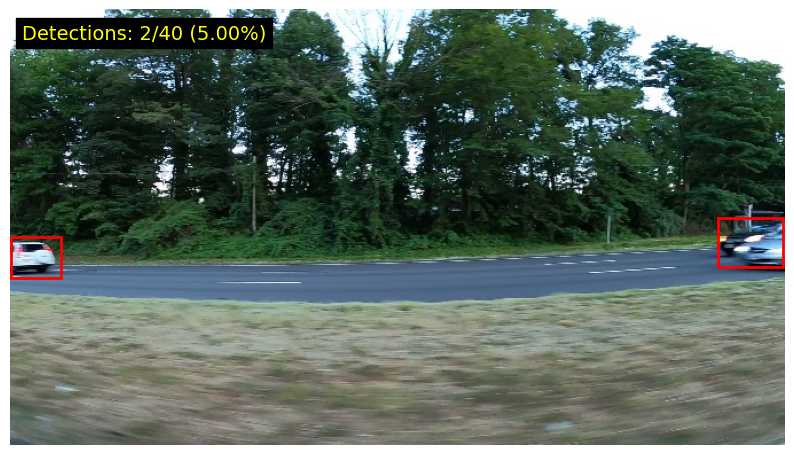

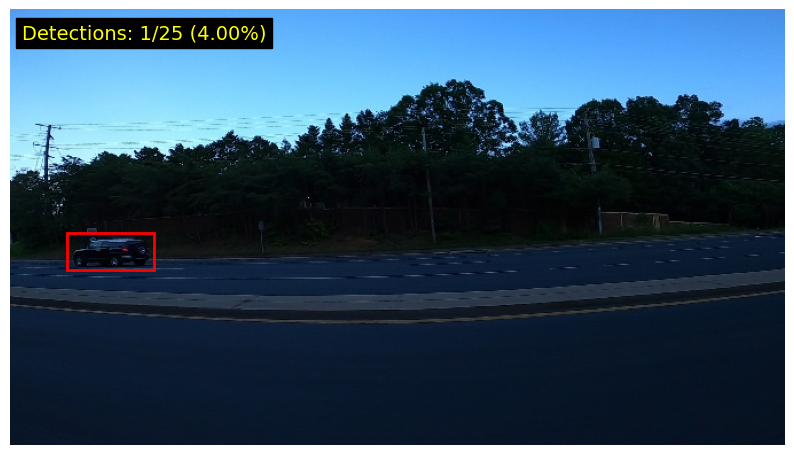

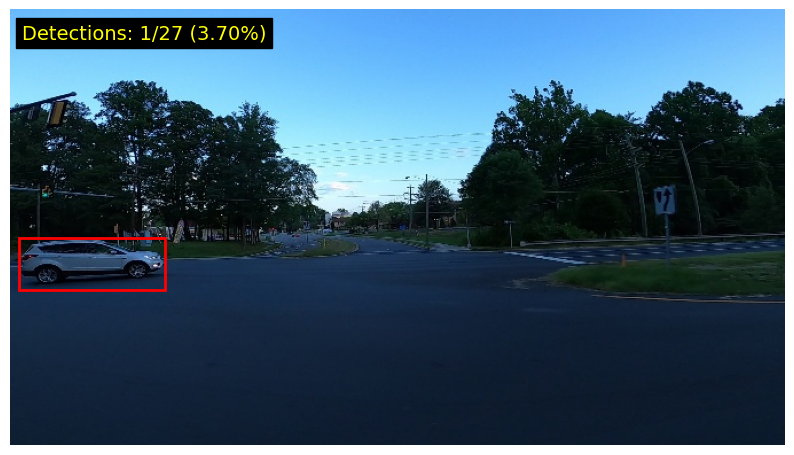

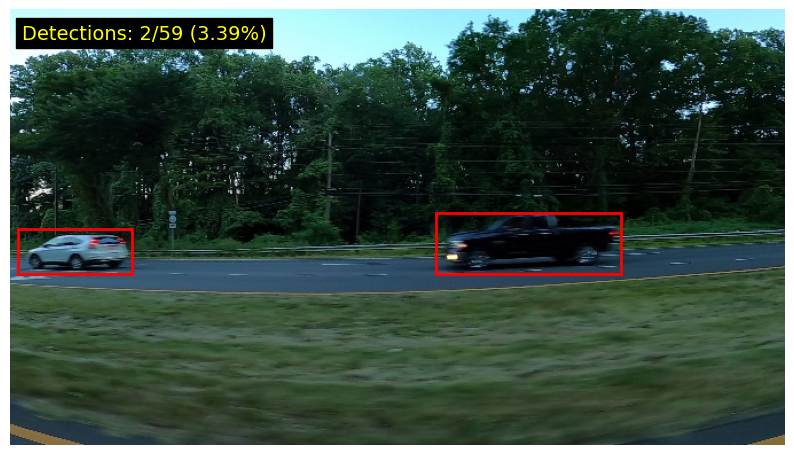

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

model.eval()
images, targets = next(iter(val_loader))
images = list(img.to(device) for img in images)
outputs = model(images)

for i in range(len(images)):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()

    boxes = outputs[i]['boxes'].detach().cpu().numpy()
    scores = outputs[i]['scores'].detach().cpu().numpy()

    total_preds = len(scores)
    kept_boxes = 0

    for box, score in zip(boxes, scores):
        if score > 0.5:
            kept_boxes += 1
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    percent = (kept_boxes / total_preds * 100) if total_preds > 0 else 0

    # Show text on top left corner of the image
    ax.text(10, 25, f"Detections: {kept_boxes}/{total_preds} ({percent:.2f}%)",
            color='yellow', fontsize=14, backgroundcolor='black')

    plt.axis('off')
    plt.show()
